<a href="https://colab.research.google.com/github/WilliamAshbee/3d-synth-data/blob/main/3d_2dreshaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vit-pytorch

In [2]:
# -*- coding: utf-8 -*-
"""Sergey_bootcamp_randomsynthetic_circle.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/Sergey_bootcamp_randomsynthetic_circle.ipynb
"""

from scipy.special import spherical_jn as besseli
import numpy as np
from scipy import *
from math import *
import matplotlib.pyplot as plt

from scipy.special import iv as besseli
import matplotlib.pyplot as plt
import numpy as np
from scipy import *
from math import *
#import pylab as plt


import torch
from skimage import filters
import math

from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from vit_pytorch import ViT

global xbaseline
xbaseline = np.random.randn(2, 1000)



def vmf(mu, kappa, x):
    # single point function
    d = mu.shape[0]
    # compute in the log space
    logvmf = (d//2-1) * np.log(kappa) - np.log((2*np.pi)**(d/2)*besseli(d//2-1,kappa)) + kappa * np.dot(mu,x)
    return np.exp(logvmf)

def apply_vmf(x, mu, kappa, norm=1.0):
    delta = 1.0+vmf(mu, kappa, x)
    y = x * np.c_[delta,delta].T
    return y


def createDataset(pltFig = True,numFigs = 100,numPoints = 1000):
  global xbaseline
  dimensions = 2
  x = np.zeros((numFigs,dimensions, numPoints))   #this could get interesting! why does it fail on the random permuted version 
  xnormed = xbaseline
  xnormed = xnormed/np.linalg.norm(xnormed, axis=0)
  x[:,:,:] = xnormed
  
  for k in range(numFigs):
    if pltFig:
      fig = plt.figure()
    w = np.random.rand(11)
    w = w/np.sum(w)
    xnormed = x[k,:,:]#/np.linalg.norm(x[k,:,:], axis=0)
    xx = x[k,:,:]*w[0]
    it = 10
    for i in range(it):
        kappa = np.random.randint(5, 100)
        mu = np.random.randn(2); mu = mu/np.linalg.norm(mu)
        y = apply_vmf(xnormed, mu, kappa)
        xx += w[i+1]*y
    x[k,:,:] = xx
    if pltFig:
      plt.plot(x[k,0,:], x[k,1,:], ',-', ms=1)
      print(xx.shape)
      plt.gca().set_aspect(1)
      plt.show()

  return x  



global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def convex_combination_matrix(length = 10):
    
    
    canvas = torch.zeros((length,side, side))
    points = createDataset(pltFig = False,numFigs=length,numPoints=1000).transpose(0,2,1)
    print('pointshape',points.shape)
    maxP = np.max(points,axis=1).reshape(length,1,2)
    minP = np.min(points,axis=1).reshape(length,1,2)
    points = (points - minP)*side*.999999 *(1.0/ (maxP - minP))
    points = torch.from_numpy(points)

    

    
    assert points.shape == (length,1000,2)
    

    for l in range(length):
        canvas[l,points[l,:,0].type(torch.LongTensor),points[l,:,1].type(torch.LongTensor)]=1.0
        
    
    print('canvshape',canvas.shape)
    print('sumcanvas',torch.sum(canvas)/length)
    
    return {
        'canvas': canvas, 
        'points':points}

def plot_one(img,xs,ys,i=0):
  plt.subplot(10,10,i+1)
  plt.imshow(img.T, cmap=plt.cm.gray_r)
  predres = 1000
  s = [.001 for x in range(predres)]
  assert len(s) == predres
  c = ['red' for x in range(predres)]
  assert len(c) == predres
  plt.plot(xs.cpu().numpy(),ys.cpu().numpy(),',', color='red',ms=.3,lw=.3)
  plt.axis('off')

def plot_all( sample = None, model = None, labels = None, i = 0):
    
    #make prediction
    #plot one prediction
    #or plot one ground truth
    if model != None:
        with torch.no_grad():
            global numpoints
            
            print('preloss')
            loss, out = mse_vit(sample.cuda(),labels.cuda(),model=model,ret_out = True)
            print('loss',loss)
            
            for i in range(100):
              img = sample[i,0,:,:].squeeze().cpu().numpy()
              X = out[i,:1000,0]
              Y = out[i,-1000:,1]
              plot_one(img,X,Y,i=i)
              
            
    else:
      print(sample.shape,labels.shape)
      for i in range(100):
        img = sample[i,0,:,:].squeeze().cpu().numpy()
        #print(np.sum('img',img))
        X = labels[i,:,0]
        Y = labels[i,:,1]
        plot_one(img,X,Y,i=i)
        
        
class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = convex_combination_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        canvas = canvas[idx,:,:]
        points = self.values["points"]
        points = points[idx,:]
        if len(canvas.shape) == 2:
          canvas = torch.stack([canvas,canvas,canvas],dim=0)
        else:
          canvas = torch.stack([canvas,canvas,canvas],dim=1)
        
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,loader, model):
        
        for sample, labels in loader:
          plot_all(sample = sample,model=model, labels = labels)
          break
        plt.savefig(title,dpi=600)
        plt.clf()

dataset = DonutDataset(length = 100)

mini_batch = 100
loader_demo = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=2)
DonutDataset.displayCanvas('donut.png',loader_demo, model = None)



mini_batch = 100
train_dataset = DonutDataset(length = 1000*2)
loader_train = data.DataLoader(
    train_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=train_dataset),
    num_workers=4)



v = ViT(
    image_size = (32,32),
    patch_size = 4,
    num_classes = 2000,
    dim = 2048,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

v = torch.nn.Sequential(
    v,
    torch.nn.Sigmoid()
)

img = torch.randn(100, 3, 32, 32)

preds = v(img) # (1, 1000)

model = v.cuda()

def mse_vit(input, target,model=None,ret_out = False):
  out = model(input)
  out = out.reshape(target.shape)#64, 1000, 2
  out = out*32.0#fix this
  if not ret_out:
    return torch.mean((out-target)**2)
  else:
    return torch.mean((out-target)**2),out

optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))#ideal

for epoch in range(20):
  for x,y in loader_train:
    optimizer.zero_grad()
    x = x.cuda()
    y = y.cuda()
    loss = mse_vit(x,y,model=model)
    loss.backward()
    optimizer.step()
  print('epoch',epoch,'loss',loss)

optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))#ideal

for epoch in range(2):
  for x,y in loader_train:
    optimizer.zero_grad()
    x = x.cuda()
    y = y.cuda()
    loss = mse_vit(x,y,model=model)
    loss.backward()
    optimizer.step()
  print('epoch',epoch,'loss',loss)



model = model.eval()
DonutDataset.displayCanvas('vit-training-1.png',loader_train, model = model)


mini_batch = 100
dataset = DonutDataset(length = 100)
loader_test = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)

#model = model.eval()
for x,y in loader_test:
  x = x.cuda()
  y = y.cuda()
  loss = mse_vit(x,y,model=model)
  print('validation loss',loss)
  break

DonutDataset.displayCanvas('vit-test-set-1-randomorder.png',loader_test, model = model)



pointshape (100, 1000, 2)
canvshape torch.Size([100, 32, 32])
sumcanvas tensor(123.9600)
torch.Size([100, 3, 32, 32]) torch.Size([100, 1000, 2])
pointshape (2000, 1000, 2)
canvshape torch.Size([2000, 32, 32])
sumcanvas tensor(123.6155)
epoch 0 loss tensor(6.5595, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
epoch 1 loss tensor(5.9266, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [4]:
from scipy import *
from math import *
import numpy as np


def clean_float(fnumber):
    tol = 0.0000001
    if fnumber < tol and fnumber > -1.0 * tol:
        fnumber = 0.0
    return fnumber


def topology(frequency):
    vertex = 3
    for i in range(2, frequency + 1):
        vertex += i + 1
    faces = frequency * frequency
    edges = (vertex + faces) - 1
    return [vertex, faces, edges]


def vlabels(vertex, faces, edges, frequency):
    labels = zeros([2, vertex + 1])
    points = zeros([3, vertex + 1])
    count = 1
    for i in range(0, frequency + 1):
        for j in range(0, i + 1):
            labels[0, count] = i
            labels[1, count] = j
            points[0, count] = j
            points[1, count] = i - j
            points[2, count] = frequency - i
            count += 1
    return [points, labels]


def vcoords(points, labels, frequency):
    DEG_TO_RAD = .0174532925199433
    RAD_TO_DEG = 57.2957795130824
    results = points.copy()
    results = results * 0.0
    for i in range(1, size(points, 1)):
        X = points[0, i] * sin(72.0 * DEG_TO_RAD)
        Y = points[1, i] + (points[0, i] * cos(72.0 * DEG_TO_RAD))
        Z = frequency / 2.0 + (points[2, i] / (2.0 * cos(36.0 * DEG_TO_RAD)))
        if (X == Y):
            results[0, i] = 0.0
        elif Y == 0:
            results[0, i] = 90.0
        else:
            results[0, i] = atan(X / Y) * RAD_TO_DEG
        # adjust value to correct quadrant
        if results[0, i] < 0.0:
            results[0, i] += 180
        # now calculate theta
        if (Z == 0):
            results[1, i] = 90.0
        else:
            results[1, i] = atan((pow(pow(X, 2.0) + pow(Y, 2.0), 0.5)) / Z) * RAD_TO_DEG
        # make sure the right quadrant is used
        if (results[1, i] < 0.0):
            results[1, i] += 180.0
        results[2, i] = 1
    return results


def oneface(labels, faceidx, vertex, count, i):
    faceidx[0, count] = i
    for j in range(i, vertex + 1):
        if ((labels[0, j] == labels[0, i] + 1) and (labels[1, j] == labels[1, i])):
            break
    faceidx[1, count] = j
    for k in range(i, vertex + 1):
        if ((labels[0, k] == labels[0, j]) and (labels[1, k] == labels[1, j] + 1)):
            break
    faceidx[2, count] = k
    return 0


def twoface(labels, faceidx, vertex, count, i):
    faceidx[0, count] = i
    for j in range(i, vertex + 1):
        if ((labels[0, j] == labels[0, i] + 1) and (labels[1, j] == labels[1, i] + 1)):
            break
    faceidx[1, count] = j
    for k in range(i, vertex + 1):
        if ((labels[0, k] == labels[0, j] - 1) and (labels[1, k] == labels[1, j])):
            break
    faceidx[2, count] = k
    return 0


def face_factor(vertex, faces, frequency, labels):
    faceidx = zeros([3, faces + 1])
    count = 1
    for i in range(1, vertex - (frequency + 1) + 1):
        if (labels[0, i] == 0 and labels[1, i] == 0):
            oneface(labels, faceidx, vertex, count, i)
            count += 1
        elif (labels[1, i] == 0):
            oneface(labels, faceidx, vertex, count, i)
            count += 1
            twoface(labels, faceidx, vertex, count, i)
            count += 1
        elif (labels[1, i] == labels[0, i]):
            oneface(labels, faceidx, vertex, count, i)
            count += 1
        else:
            oneface(labels, faceidx, vertex, count, i)
            count += 1
            twoface(labels, faceidx, vertex, count, i)
            count += 1
    return faceidx


def sphere2cart(vertices):
    DEG_TO_RAD = .0174532925199433
    for i in range(1, size(vertices, 1)):
        sX = clean_float(cos(vertices[0, i] * DEG_TO_RAD) \
                         * sin(vertices[1, i] * DEG_TO_RAD))
        sY = clean_float(sin(vertices[0, i] * DEG_TO_RAD) \
                         * sin(vertices[1, i] * DEG_TO_RAD))
        sZ = clean_float(cos(vertices[1, i] * DEG_TO_RAD))
        vertices[0, i] = sX
        vertices[1, i] = sY
        vertices[2, i] = sZ
    return 0


def points_facets(frequency):
    [v, f, e] = topology(frequency)
    [vp, lp] = vlabels(v, f, e, frequency)
    vc = vcoords(vp, lp, frequency)
    fidx = face_factor(v, f, frequency, lp)
    sphere2cart(vc)
    return [vc, fidx]


# returns spherical point coordinates
def spoints_facets(frequency):
    [v, f, e] = topology(frequency)
    [vp, lp] = vlabels(v, f, e, frequency)
    vc = vcoords(vp, lp, frequency)
    fidx = face_factor(v, f, frequency, lp)
    return [vc, fidx]


def rotate_phi(phi, phi1, theta1, theta2):
    DEG_TO_RAD = .0174532925199433
    RAD_TO_DEG = 57.2957795130824
    result = (sin(theta1 * DEG_TO_RAD) * sin((phi - phi1) * DEG_TO_RAD)) \
             / sin(theta2 * DEG_TO_RAD)
    if (result > 1.0):
        result = 1.0
    elif (result < -1.0):
        result = -1.0
    return asin(result) * RAD_TO_DEG


def rotate_theta(phi, phi1, theta, theta1):
    DEG_TO_RAD = .0174532925199433
    RAD_TO_DEG = 57.2957795130824
    result = cos(theta1 * DEG_TO_RAD) * cos(theta * DEG_TO_RAD) + \
             sin(theta1 * DEG_TO_RAD) * sin(theta * DEG_TO_RAD) * \
             cos((phi - phi1) * DEG_TO_RAD)
    if (result > 1.0):
        result = 1.0
    elif (result < -1.0):
        result = -1.0
    return acos(result) * RAD_TO_DEG


def icosa_sphere(facenum, points):
    RAD_TO_DEG = 57.2957795130824
    sphere_pnt = points.copy() * 0.0
    if (facenum >= 0 and facenum <= 4):
        for i in range(1, size(points, 1)):
            sphere_pnt[0, i] = points[0, i] + 72.0 * facenum
            sphere_pnt[1, i] = points[1, i]
            sphere_pnt[2, i] = 1.0
    elif (facenum >= 5 and facenum <= 9):
        k = facenum - 5  # phi rotation factor
        for i in range(1, size(points, 1)):
            sphere_pnt[1, i] = rotate_theta(36.0, points[0, i], \
                                            (180.0 - (atan(2.0) * RAD_TO_DEG)), \
                                            points[1, i])
            sphere_pnt[0, i] = (rotate_phi(36.0, points[0, i], points[1, i], \
                                           sphere_pnt[1, i]) + 36.0) + 72.0 * k
            sphere_pnt[2, i] = 1.0
    elif (facenum >= 10 and facenum <= 14):
        k = facenum - 10  # phi rotation factor
        for i in range(1, size(points, 1)):
            sphere_pnt[1, i] = 180.0 - rotate_theta(36.0, points[0, i], \
                                                    (180.0 - (atan(2.0) * RAD_TO_DEG)), \
                                                    points[1, i])
            sphere_pnt[0, i] = (rotate_phi(36.0, points[0, i], points[1, i], \
                                           sphere_pnt[1, i]) + 36.0) + 72.0 * k + 36.0
            sphere_pnt[2, i] = 1.0
    else:
        k = facenum - 15  # phi rotation factor
        for i in range(1, size(points, 1)):
            sphere_pnt[0, i] = (points[0, i] + 72.0 * k) + 36.0
            sphere_pnt[1, i] = 180.0 - points[1, i]
            sphere_pnt[2, i] = 1.0
    return sphere_pnt


def icosphere(maxlevel, R):
    [spoints, sfacets] = spoints_facets(maxlevel)
    sfacets = sfacets - 1
    pp = []
    for fnum in range(0, 20):
        points = icosa_sphere(fnum, spoints)
        sphere2cart(points)
        points = points * R
        pp.append(points)
    return np.hstack(pp)

In [6]:
from scipy.special import iv as besseli
import numpy as np
import matplotlib.pyplot as plt
#import icosahedron as ico#local file
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

import torch
import numpy as np
import pylab as plt
import math

from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

def vmf(mu, kappa, x):
    # single point function
    d = mu.shape[0]
    # compute in the log space
    logvmf = (d//2-1) * np.log(kappa) - np.log((2*np.pi)**(d/2)*besseli(d//2-1,kappa)) + kappa * np.dot(mu,x)
    return np.exp(logvmf)

def apply_vmf(x, mu, kappa, norm=1.0):
    delta = 1.0+vmf(mu, kappa, x)
    y = x * np.vstack([np.power(delta,3)]*x.shape[0])
    return y


def dedup(mat):
    mat = mat - np.mean(mat, axis=1).reshape(3, 1)
    # datetime object containing current date and time
    now = datetime.now()
    start = now.strftime("%d/%m/%Y %H:%M:%S")
    mat = (mat * (1.0 / np.linalg.norm(mat, axis=0).reshape(1, -1)))
    similarities = cosine_similarity(mat.T)
    similarities = similarities >.99999
    similarities = np.triu(similarities)  # upper triangular
    np.fill_diagonal(similarities, 0)  # fill diagonal
    similarities = np.sum(similarities, axis=0)
    similarities = similarities == 0  # keep values that are no one's duplicates
    mat = mat[:, similarities]
    now = datetime.now()
    end = now.strftime("%d/%m/%Y %H:%M:%S")
    return mat

global firstDone
firstDone = False
global x
x = icosphere(30, 1.3)
ind = (x[0, :] ** 2 + x[1, :] ** 2 + x[2, :] ** 2) >= (
            np.median((x[0, :] ** 2 + x[1, :] ** 2 + x[2, :] ** 2)) - .0001)  # remove zero points
x = x[:, ind]  # fix to having zero values
x = dedup(x)


def createOneMutatedIcosphere():
    global firstDone
    global x
    numbumps = 50
    w = np.random.rand(numbumps)
    w = w/np.sum(w)


    #xnormed = x/np.linalg.norm(x, axis=0)
    xnormed = x#norming in dedup now
    xx = np.zeros_like(xnormed)

    for i in range(numbumps):
        kappa = np.random.randint(1, 200)
        mu = np.random.randn(3); mu = mu/np.linalg.norm(mu)
        y = apply_vmf(xnormed, mu, kappa)
        xx += w[i]*y

    return xx


np.random.seed(0)


global numpoints
numpoints = 9002
side = 8
sf = .99999
xs = np.zeros((side,side,side))
ys = np.zeros((side,side,side))
zs = np.zeros((side,side,side))

for i in range(side):
    xs[i,:,:] = i+.5
    ys[:,i,:] = i+.5
    zs[:,:,i] = i+.5

def rasterToXYZ(r):#may need to be between 0 and 7 instead of 0 and side*sf
    #may be better to just keep it between 0 and 1 
    a = np.copy(r)
    xr = (xs * a)[r == 1]
    yr = (ys * a)[r == 1]
    zr = (zs * a)[r == 1]

    #xr = side*sf*(xr - np.min(xr)) * (1.0 / (np.max(xr) - np.min(xr)))
    #yr = side*sf*(yr - np.min(yr)) * (1.0 / (np.max(yr) - np.min(yr)))
    #zr = side*sf*(zr - np.min(zr)) * (1.0 / (np.max(zr) - np.min(zr)))

    #xr = side*xr
    #yr = side*yr
    #zr = side*zr

    return xr,yr,zr

def mutated_icosphere_matrix(length=10,canvas_dim=8):
    points = torch.zeros(length, numpoints, 3).type(torch.FloatTensor)
    canvas = torch.zeros(length,canvas_dim,canvas_dim,canvas_dim).type(torch.FloatTensor)


    for l in range(length):
        xx = createOneMutatedIcosphere()
        xx = (xx - np.expand_dims(np.min(xx, axis=1), axis=1)) * np.expand_dims(
            1.0 / (np.max(xx, axis=1) - np.min(xx, axis=1)), axis=1)
        xx = torch.from_numpy(xx)
        xx = xx*sf
        print(xx.shape)
        x = xx[0,:]
        y = xx[1,:]
        z = xx[2,:]

        print('xyzshape',x.shape,y.shape,z.shape)
        
        print('x range',torch.max(x),torch.min(x))
        print('y range',torch.max(y),torch.min(y))
        print('z range',torch.max(z),torch.min(z))
        
        points[l, :, 0] = x[:]  # modified for lstm discriminator
        points[l, :, 1] = y[:]  # modified for lstm discriminator
        points[l, :, 2] = z[:]  # modified for lstm discriminator
        
        canvas[l, (x*side*sf).type(torch.LongTensor), (y*side*sf).type(torch.LongTensor), (z*side*sf).type(torch.LongTensor)] = 1.0


    return {
        'canvas': canvas,
        'points': points.type(torch.FloatTensor)}


def plot_one(fig,img, xx, i=0):
    print(xx.shape)
    predres = numpoints
    s = [.001 for x in range(predres)]
    assert len(s) == predres
    c = ['red' for x in range(predres)]
    s = [.01 for x in range(predres)]
    assert len(s) == 9002
    assert len(c) == predres
    ax = fig.add_subplot(10, 10, i + 1,projection='3d')
    ax.set_axis_off()

    redx = xx[:, 0]*side*sf
    redy = xx[:, 1]*side*sf
    redz = xx[:, 2]*side*sf
    print()
    ax.scatter(xx[:, 0]*side*sf, xx[:, 1]*side*sf,xx[:, 2]*side*sf, marker=',',  c='red',s=.005,lw=.005)
    gtx,gty,gtz = rasterToXYZ(img)
    print('gt size',gtx.shape,gty.shape,gtz.shape)
    ax.scatter(gtx, gty, gtz, marker = ',', c='black',s=.005,lw=.005)

    print('begin')
    print('xxshape', xx.shape)
    print('tempmax', torch.max(xx[:, 0]))

    gtx = torch.from_numpy(gtx)
    gty = torch.from_numpy(gty)
    gtz = torch.from_numpy(gtz)

    print('maxes')
    print("xx from points")
    print(torch.max(xx[:, 0]), torch.max(xx[:, 1]), torch.max(xx[:, 2]))
    print(torch.min(xx[:, 0]), torch.min(xx[:, 1]), torch.min(xx[:, 2]))
    print('from redx,redy,redz')
    print(torch.max(redx), torch.max(redy), torch.max(redz))
    print(torch.min(redx), torch.min(redy), torch.min(redz))
    
    print('gtxyz from raster')
    print(torch.max(gtx), torch.max(gty), torch.max(gtz))
    print(torch.min(gtx), torch.min(gty), torch.min(gtz))


def plot_all(sample=None, model=None, labels=None, i=0):
    if model != None:
        with torch.no_grad():
            global numpoints

            print('preloss')
            loss, out = mse_vit(sample.cuda(), labels.cuda(), model=model, ret_out=True)
            print('loss', loss)
            fig = plt.figure()
            for i in range(100):
                img = sample[i, 0, :, :].squeeze().cpu().numpy()
                X = out[i, :1000, 0]
                Y = out[i, -1000:, 1]

                plot_one(fig,img, X, Y, i=i)
    else:
        print(sample.shape, labels.shape)
        fig = plt.figure()
        for i in range(100):
            img = sample[i, :, :,:].squeeze().cpu().numpy()
            xx = labels[i, :]
            plot_one(fig,img, xx, i=i)


class MutatedIcospheresDataset(torch.utils.data.Dataset):
    def __init__(self, length=10,canvas_dim = 8):
        canvas_dim=side
        self.length = length
        self.values = mutated_icosphere_matrix(length,canvas_dim)
        self.canvas_dim = canvas_dim
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length

        count = 0
        for i in range(self.length):
            a = self[i]
            c = a[0][0, :, :]
            for el in a[1]:
                y, x = (int)(el[1]), (int)(el[0])

                if x < side - 2 and x > 2 and y < side - 2 and y > 2:
                    if c[y, x] != 1 and \
                            c[y + 1, x] != 1 and c[y + 1, -1 + x] != 1 and c[y + 1, 1 + x] != 1 and \
                            c[y - 1, x] != 1 and c[y, -1 + x] != 1 and c[y, 1 + x] != 1:
                        count += 1
        assert count == 0

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        canvas = canvas[idx, :, :]
        points = self.values["points"]
        points = points[idx, :]

        return canvas, points

    @staticmethod
    def displayCanvas(title, loader, model):
        for sample, labels in loader:
            plot_all(sample=sample, model=model, labels=labels)
            break
        plt.savefig(title, dpi=1200)
        plt.clf()


dataset = MutatedIcospheresDataset(length=100)

mini_batch = 100
loader_demo = data.DataLoader(
    dataset,
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=2)
MutatedIcospheresDataset.displayCanvas('mutatedicospheres.png', loader_demo, model=None)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:172: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, u

torch.Size([3, 9002])
xyzshape torch.Size([9002]) torch.Size([9002]) torch.Size([9002])
x range tensor(1.0000, dtype=torch.float64) tensor(0., dtype=torch.float64)
y range tensor(1.0000, dtype=torch.float64) tensor(0., dtype=torch.float64)
z range tensor(1.0000, dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([3, 9002])
xyzshape torch.Size([9002]) torch.Size([9002]) torch.Size([9002])
x range tensor(1.0000, dtype=torch.float64) tensor(0., dtype=torch.float64)
y range tensor(1.0000, dtype=torch.float64) tensor(0., dtype=torch.float64)
z range tensor(1.0000, dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([3, 9002])
xyzshape torch.Size([9002]) torch.Size([9002]) torch.Size([9002])
x range tensor(1.0000, dtype=torch.float64) tensor(0., dtype=torch.float64)
y range tensor(1.0000, dtype=torch.float64) tensor(0., dtype=torch.float64)
z range tensor(1.0000, dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([3, 9002])
xyzshape torch.Size([9002]) to

<Figure size 432x288 with 0 Axes>

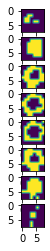

In [23]:
a = dataset[0][0]
a = a.reshape(8,-1)
a[:,8:(8+8)].shape
init = 810
for i in range(8):
  init+=1
  plt.subplot(init)
  plt.imshow(a[:,8*i:8*(i+1)])
plt.savefig('3dreshaped.png',dpi=600)